In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report, recall_score, precision_score, f1_score

from sklearn.naive_bayes import MultinomialNB

In [2]:
df = pd.read_csv('../data/reviews_with_ratings_cleaned.csv', index_col = 'Unnamed: 0', keep_default_na = False)
df.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,avg_rating,avg_score_below_4,avg_score_below_5th_percentile,comments_clean
119122,18288362,300153629,2018-08-01,1365558,Travis,incredible location and value in a quiet build...,4.854286,0,0,incredible location and value in a quiet build...
123686,18896504,554329507,2019-10-26,303367305,范黎明（Fan Liming）,Mrs. Louise is a great person. She is very en...,4.628571,0,0,mrs louise is a great person she is very enthu...
273445,52636090,839911289207075691,2023-03-04,69531482,Kasee,"This was just the place for me, my husband, an...",4.917143,0,0,this was just the place for me my husband and ...
127039,19207688,247171541,2018-03-27,21141080,Erin,Our trip with Thang was good. The room and the...,4.790000,0,0,our trip with thang was good the room and the ...
267534,51440218,867392838048833141,2023-04-11,477732420,Jari-Matti,Good location next to the center. Little bit s...,4.892857,0,0,good location next to the center little bit sm...


In [3]:
df.isnull().sum()

listing_id                        0
id                                0
date                              0
reviewer_id                       0
reviewer_name                     0
comments                          0
avg_rating                        0
avg_score_below_4                 0
avg_score_below_5th_percentile    0
comments_clean                    0
dtype: int64

#### Look at below 5th percentile

In [4]:
print(df['avg_score_below_5th_percentile'].value_counts()),
print('*'*30)
df['avg_score_below_5th_percentile'].value_counts(normalize = True)

avg_score_below_5th_percentile
0    320774
1      2033
Name: count, dtype: int64
******************************


avg_score_below_5th_percentile
0    0.993702
1    0.006298
Name: proportion, dtype: float64

In [5]:
X = df['comments_clean']
X.shape

(322807,)

In [6]:
y = df['avg_score_below_5th_percentile']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### Running Multinomial Naive Bayes instead of a Logistic Regression

#### Running just the best parameters from the model below

In [10]:
pipe_short = Pipeline([
    ('tf', TfidfVectorizer() ),
    ('nb', MultinomialNB() )
])

In [11]:
pipe_params_short = {
    'tf__stop_words' : ['english'],
    'tf__max_features' : [5_000], 
    'tf__min_df' : [2], # Minimum number of times a word needs to appear
    'tf__ngram_range' : [ (1,2) ]
}

In [12]:
gs_short = GridSearchCV(pipe_short, pipe_params_short, n_jobs = -1, 
                  verbose = 10)

In [13]:
gs_short.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tf__max_features': [5000], 'tf__min_df': [2],
                         'tf__ngram_range': [(1, 2)],
                         'tf__stop_words': ['english']},
             verbose=10)

In [14]:
recall_score(y_test, gs_short.predict(X_test) )

0.0

In [15]:
f1_score(y_test, gs_short.predict(X_test) )

0.0

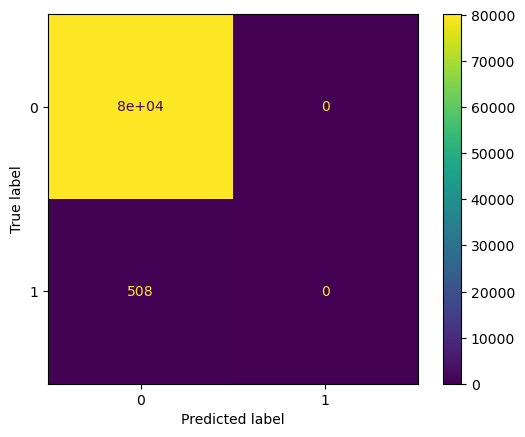

In [16]:
ConfusionMatrixDisplay.from_estimator(gs_short, X_test, y_test);

#### Full Grid Search parameters

In [32]:
pipe = Pipeline([
    ('tf', TfidfVectorizer() ),
    ('nb', MultinomialNB() )
])

In [33]:
pipe_params = {
    'tf__stop_words' : ['english'],
    'tf__max_features' : [5_000, 10_000, 30_000], 
    'tf__min_df' : [2 ,5, 10, 25], # Minimum number of times a word needs to appear
    'tf__ngram_range' : [ (1,1), (1,2), (1,3) ]
}

In [34]:
gs = GridSearchCV(pipe, pipe_params, n_jobs = -1, 
                  verbose = 10)

In [35]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tf__max_features': [5000, 10000, 30000],
                         'tf__min_df': [2, 5, 10, 25],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tf__stop_words': ['english']},
             verbose=10)

#### Best Params - Max Features is 5000, min_df is 2, n_gram range is (1,2)

In [37]:
gs.best_params_

{'tf__max_features': 5000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': 'english'}

In [36]:
gs.best_score_

0.9937010801098698

#### Best score is 99.3% - but similar to majority class

In [38]:
gs.best_score_ - df['avg_score_below_5th_percentile'].value_counts(normalize = True)[0]

-1.0391130714770824e-06

#### It never predicts the minority class

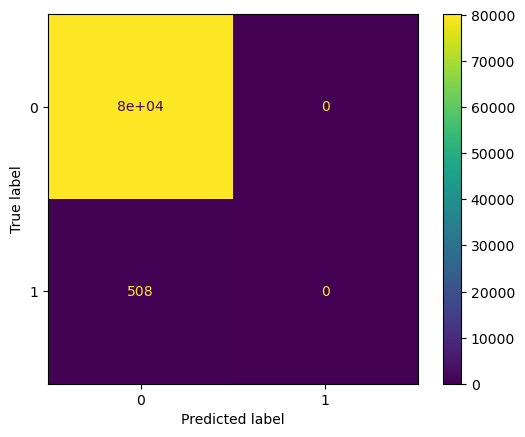

In [39]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

In [41]:
recall_score(y_test, gs.predict(X_test))

0.0

In [17]:
prob_df = pd.DataFrame(gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() ), columns = ['above_5th_percentile', 'below_5th_percentile'])
prob_df

,above_5th_percentile,below_5th_percentile
0,0.906198,0.093802
1,0.728976,0.271024
2,0.622167,0.377833
3,0.716586,0.283414
4,0.696334,0.303666
...,...,...
29995,0.898788,0.101212
29996,0.093186,0.906814
29997,0.910798,0.089202
29998,0.907113,0.092887


In [18]:
feature_words = pd.DataFrame( gs.best_estimator_.named_steps.tf.get_feature_names_out(), columns = ['features'])
feature_words

,features
0,00
1,00 pm
2,000
3,00am
4,10
...,...
29995,있어서
29996,있었습니다
29997,정말
29998,좋았습니다


In [20]:
word_probs = feature_words.join(prob_df)
word_probs.sort_values('below_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
13958,jasmine,4.352548e-07,1.000000
29921,yousong,4.160599e-05,0.999958
7409,dee,4.350937e-05,0.999956
27507,todd,3.944948e-04,0.999606
24389,sireenat,9.460015e-04,0.999054
28588,views,1.222327e-03,0.998778
6170,concierge,1.891628e-03,0.998108
28089,tyler,2.011699e-03,0.997988
13964,jay,2.468210e-03,0.997532
11098,grace,2.491228e-03,0.997509


In [21]:
word_probs = feature_words.join(prob_df)
word_probs.sort_values('above_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
5616,comfortable,0.999283,0.000717
23059,restaurants,0.999149,0.000851
20329,place clean comfortable,0.999131,0.000869
26654,super clean comfortable,0.998992,0.001008
26647,super clean,0.998739,0.001261
12510,highly recommend staying,0.998645,0.001355
1294,apartment comfortable,0.998569,0.001431
16397,loved stay,0.998514,0.001486
15823,location perfect,0.998377,0.001623
12486,highly recommend,0.998369,0.001631


In [22]:
pd.set_option('display.max_colwidth', 400)
df[['avg_rating', 'avg_score_below_4', 'comments_clean']] [df['comments_clean'].str.contains('jasmine')].sort_values('avg_rating')

,avg_rating,avg_score_below_4,comments_clean
302045,4.352857,0,initially at booking jasmine wasn t responsive to questions however as the date approached and came she was very responsive had all the items to help our holiday away from home feel homey enjoyed our stay
302043,4.352857,0,jasmine was very nice she was very responsive and made excellent recommendations public transit was very close by so even though there wasn t much to do in the area we were able to get where we needed with ease would stay again
302040,4.352857,0,a great place and responsive host the place was very nice and the instructions were clear mattresses were very comfortable the kitchen was very nice and clean and the living room was very nice jasmine was great at checking in and responding to a couple questions we had would definitely stay here again
302038,4.352857,0,jasmine house was very clean and nice and she got lots of kitchen equipment for people who like to cook we will be here again for sure
302037,4.352857,0,very cozy house and communication with jasmine was always very fluid everything was great
...,...,...,...
108491,4.902857,0,jasmine was so wonderful and quick to respond great host would definitely recommend this place to anyone visiting the dc area super clean home
108485,4.902857,0,sheridan s place was absolutely darling and immaculate i have been using airbnb for the past five years and i would rate this among the top places first the decor is very vibrant homey and stylish second the room is bright with lots of natural light and very clean it even has a nice airbnb magazine the bathroom is divine fully stocked with travel sized toiletries much like you would find in a ...
108473,4.902857,0,i use airbnb frequently when i travel but had never stayed in a private room listing sheridan s place has set the bar high the entire home was nice and well decorated the neighborhood was quiet and accessible to the metro line i was primarily using on my trip the other occupants were so cool and helped with any questions i had really would book again if i needed and recommend to anyone who is ...
299406,4.954286,0,one of the best apartment among 20 places i ve stayed sparkling clean brand new facilities great decor and comfy furnitures wonderful location walkable to all restaurants and stores not to mention the most wonderful host i ve ever met sabri martin jasmine are unbelievably kind thoughtful and accommodating always respond to our messages immediately solve problems proactively and willing to go e...
